VENKATESAN Janani

In [ ]:
# for installing pyspark
!pip install pyspark==3.0.0

# mount your google drive to be able to access files from your google drive !
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 MB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 28.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044160 sha256=f3944652b561db3633e25114c7750287f346f64ebb1546e89f0d32aa0b1a9640
  Stored in directory: /root/.cache/pip/wheels/b1/bb/8b/ca24d3f756f2ed967225b0871898869db676eb5846df5adc56
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Real Estate Analysis") \
    .getOrCreate()

# Load the dataset
data = spark.read.csv("drive/MyDrive/PYSPARK-COURSE/project_data_real_estate_toulouse_and_suburbs.csv", header=True, sep=";")

data.show()
total_data=data.count()
print("Number of rows :" ,total_data)

+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|            SaleType|    Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+
|15/01/2019|                SALE|    95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|21/01/2019|                SALE|   261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|03/01/2019|                SALE|   101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|11/01/2019|                SALE|    59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|15/01/2019|                SALE|   179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
|15/01/2019|            

In [ ]:
houses_df = data[data['ResidenceType'] == 'HOUSE']
houses_count = houses_df.count()

apartments_df = data[data['ResidenceType'] == 'APARTMENT']
apartments_count = apartments_df.count()

print("Number of houses :", houses_count)
print("Number of apartments :", apartments_count)

Number of houses : 17630
Number of apartments : 62488


# 1. Calculating price per square meter

For Houses

In [ ]:
from pyspark.sql.functions import col

house_sqm = houses_df.withColumn("PricePerSqMeter", col("Price") / col("LandArea"))
house_sqm.show()

#Calculating the average

avg_price_per_sq_meter = house_sqm.agg({"PricePerSqMeter": "avg"}).collect()[0][0]
print(f"Average Price Per Square Meter: {avg_price_per_sq_meter}")

+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+------------------+
|  SaleDate|            SaleType|    Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|   PricePerSqMeter|
+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+------------------+
|15/01/2019|                SALE|    95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|188.11881188118812|
|21/01/2019|                SALE|   261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311| 841.4790996784566|
|15/01/2019|                SALE|   179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263| 680.6083650190114|
|15/01/2019|                SALE|   209300|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        74|     257| 814.3968871595331|
|18/01/2019| 

We observe that the average price per square meter is approximately 1066.73.

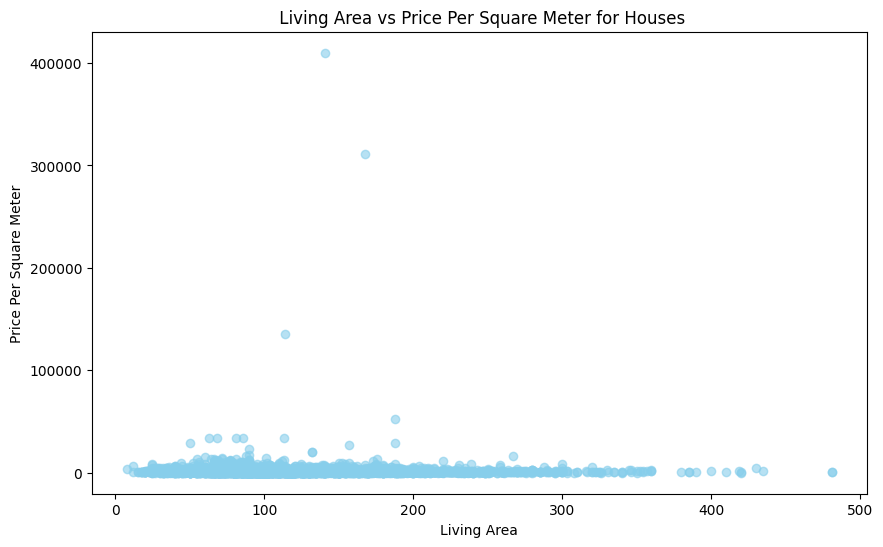

In [ ]:
import matplotlib.pyplot as plt
# Filtering out None values and extract LivingArea and PricePerSqMeter values
living_area_values = []
price_per_sq_meter_values = []
for row in house_sqm.select("LivingArea", "PricePerSqMeter").collect():
    if row.PricePerSqMeter is not None:
        living_area_values.append(float(row.LivingArea))
        price_per_sq_meter_values.append(float(row.PricePerSqMeter))

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(living_area_values, price_per_sq_meter_values, color='skyblue', alpha=0.6)
plt.title(' Living Area vs Price Per Square Meter for Houses')
plt.xlabel('Living Area')
plt.ylabel('Price Per Square Meter')
plt.show()


1.   Most of the points are concentrated near the   lower end.
2.   There is high variability in price per square meter among the smaller properties compared with the larger ones.



For Apartments

In [ ]:
from pyspark.sql.functions import col , avg

apartments_sqm = apartments_df.withColumn("PricePerSqMeter", col("Price") / col("LivingArea"))
apartments_sqm.show()

#Average
average_price_per_sq_meter = apartments_sqm.agg(avg("PricePerSqMeter")).collect()[0][0]
print("Average Price Per Square Meter for Apartments:", average_price_per_sq_meter)

+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+-----------+------------------+
|  SaleDate|            SaleType|    Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|unused_area|   PricePerSqMeter|
+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+-----------+------------------+
|03/01/2019|                SALE|   101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|      -44.0|2295.4545454545455|
|11/01/2019|                SALE|    59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|      -26.0|2288.4615384615386|
|07/02/2019|                SALE|146106,12|   31270|VILLENEUVE TOLOSANE|      3|     1|    APARTMENT|        64|       0|      -64.0|              null|
|08/01/2018|                SALE|   123000|   31270|VILLENEUVE TOLOSANE|      3|  

We observe that the average price per square meter is approximately 11838.16.

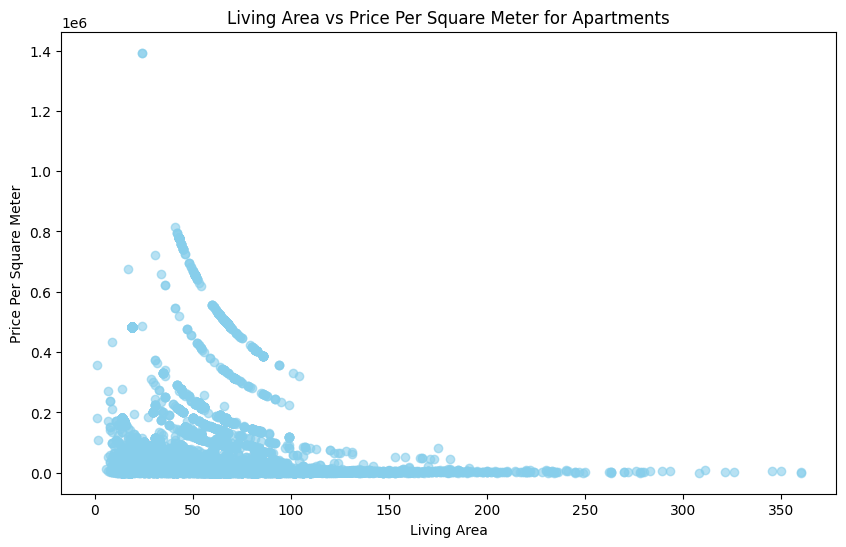

In [ ]:
import matplotlib.pyplot as plt

# Filtering out None values and extract LivingArea and PricePerSqMeter values for apartments
apartments_living_area_values = []
apartments_price_per_sq_meter_values = []
for row in apartments_sqm.select("LivingArea", "PricePerSqMeter").collect():
    if row.PricePerSqMeter is not None:
        apartments_living_area_values.append(float(row.LivingArea))
        apartments_price_per_sq_meter_values.append(float(row.PricePerSqMeter))

# Plotting the scatter plot for apartments
plt.figure(figsize=(10, 6))
plt.scatter(apartments_living_area_values, apartments_price_per_sq_meter_values, color='skyblue', alpha=0.6)
plt.title('Living Area vs Price Per Square Meter for Apartments')
plt.xlabel('Living Area')
plt.ylabel('Price Per Square Meter')
plt.show()




1.   we can Observe a wide range of price per Sq Meter for apartments with smaller Living areas.
2. The price per square meter tends to decrease as the living area increases.



# Evolution of price per sq meter for house and apartments

+----+--------------------+
|Year|avg(PricePerSqMeter)|
+----+--------------------+
|2015|  1024.2857217643962|
|2016|  1120.6163772093312|
|2017|   996.0385926639703|
|2018|   1115.591849297992|
|2019|   1106.288034598668|
+----+--------------------+



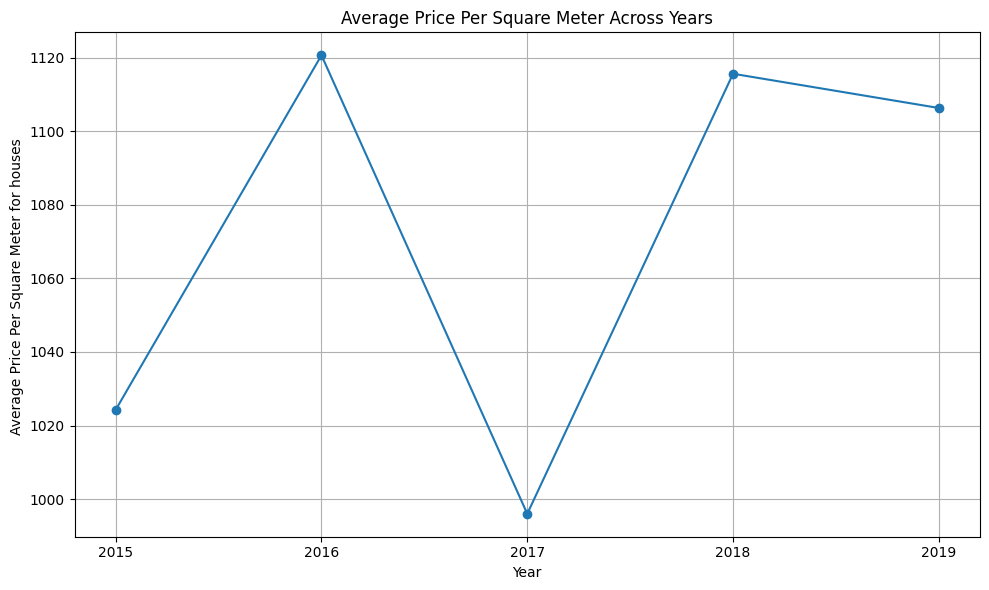

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import substring

# Extract year from SaleDate
houses_year = house_sqm.withColumn("Year", substring("SaleDate", 7, 4).cast("int"))

# Group by year and calculate the average price per square meter
avg_price_per_sqm_year = houses_year.groupBy("Year").avg("PricePerSqMeter").orderBy("Year")

# Extract years and average prices per square meter
years = [row.Year for row in avg_price_per_sqm_year.collect()]
avg_prices_per_sq_meter = [row["avg(PricePerSqMeter)"] for row in avg_price_per_sqm_year.collect()]

# Display the average price per square meter across each year in a table
avg_price_per_sqm_year.show()


# Plotting the average price per square meter across each year
plt.figure(figsize=(10, 6))
plt.plot(years, avg_prices_per_sq_meter, marker='o', linestyle='-')
plt.title('Average Price Per Square Meter Across Years')
plt.xlabel('Year')
plt.ylabel('Average Price Per Square Meter for houses ')
plt.grid(True)
plt.xticks(years)
plt.tight_layout()
plt.show()


There is a general increase in the average price per square meter for houses from 2015-2019. But there is significant Year over Year variability. There is a notable drop in 2017, which is the lowest point of the observed period.




+----+--------------------+
|Year|avg(PricePerSqMeter)|
+----+--------------------+
|2015|  16945.013163515356|
|2016|    9926.43868504177|
|2017|  11104.291769502248|
|2018|   5050.254087396505|
|2019|  22956.021337447815|
+----+--------------------+



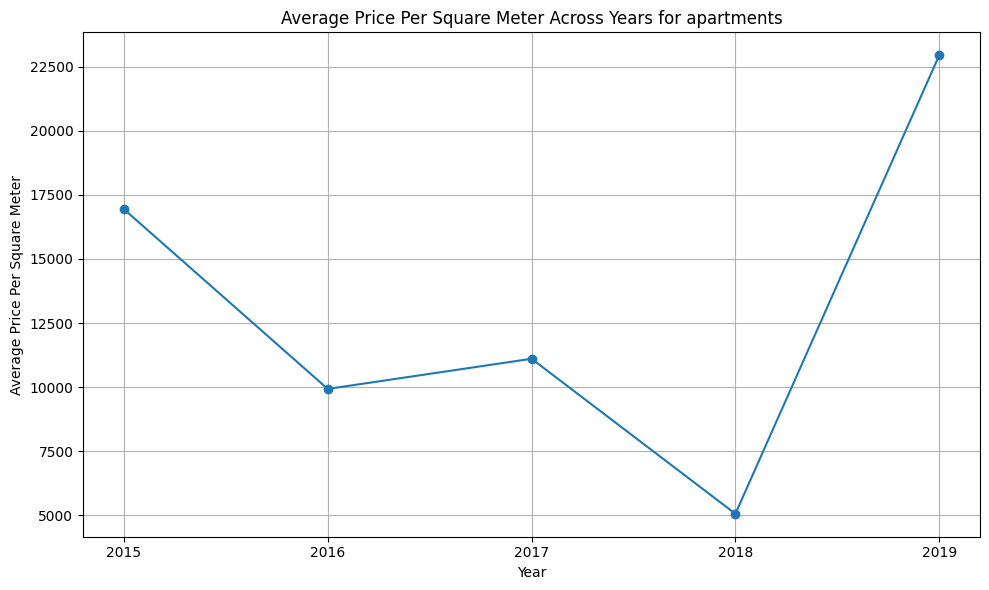

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import substring

# Extract year from SaleDate
apartments_year = apartments_sqm.withColumn("Year", substring("SaleDate", 7, 4).cast("int"))

# Group by year and calculate the average price per square meter
avg_price_per_sqm_year = apartments_year.groupBy("Year").avg("PricePerSqMeter").orderBy("Year")

# Extract years and average prices per square meter
years = [row.Year for row in avg_price_per_sqm_year.collect()]
avg_prices_per_sq_meter = [row["avg(PricePerSqMeter)"] for row in avg_price_per_sqm_year.collect()]

# Display the average price per square meter across each year in a table
avg_price_per_sqm_year.show()

# Plotting the average price per square meter across each year
plt.figure(figsize=(10, 6))
plt.plot(years, avg_prices_per_sq_meter, marker='o', linestyle='-')
plt.title('Average Price Per Square Meter Across Years for apartments')
plt.xlabel('Year')
plt.ylabel('Average Price Per Square Meter')
plt.grid(True)
plt.xticks(years)
plt.tight_layout()
plt.show()


There is significant decrease in average price per Sq meter from 2015 to 2016.Following this in 2017, there is a slight recovery. But in 2018 , there is huge dip and the lowest observed price across the years. In 2019, there is huge rise, more than doubling the previous years.

# 2. Comparing by Post codes

For House

+--------+--------------------+
|PostCode|avg(PricePerSqMeter)|
+--------+--------------------+
|   31000|  3929.9443308600776|
|   31400|  2101.8038395462468|
|   31500|   1616.587496577286|
|   31300|  1458.3146672694459|
|   31130|  1287.2186637011011|
|   31200|    1269.83500287272|
|   31100|  1049.2727045764814|
|   31650|   955.6543422143728|
|   31240|   927.7659066344393|
|   31700|   868.6954524652987|
|   31320|   851.0163701538928|
|   31770|   782.5110048190824|
|   31140|   776.6712597590027|
|   31830|   755.0444427982449|
|   31820|   740.2166061326623|
|   31270|   734.5379680405911|
|   31520|   699.6524574867327|
|   31170|   696.5839627384345|
|   31750|    659.054681706938|
|   31670|   642.9162438033767|
+--------+--------------------+
only showing top 20 rows



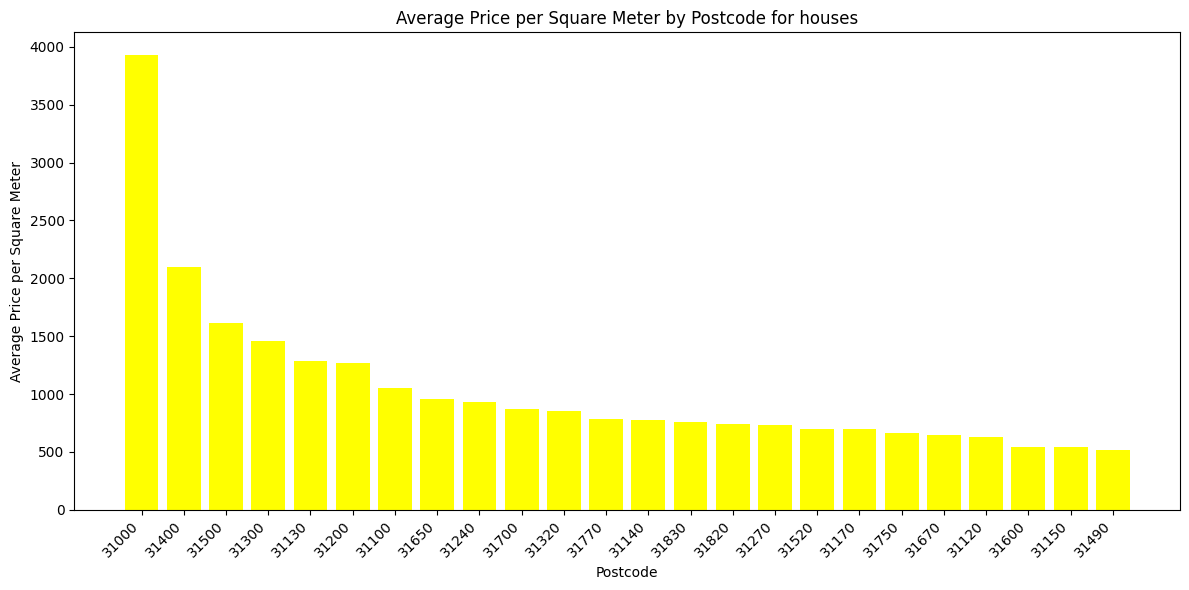

In [ ]:
postcode_df=house_sqm.groupBy('PostCode').avg('PricePerSqMeter')

sorted_postcode_df = postcode_df.orderBy('avg(PricePerSqMeter)', ascending=False)
sorted_postcode_df.show()

#plotting
import matplotlib.pyplot as plt

postcodes = [row.PostCode for row in sorted_postcode_df.collect()]
avg_price_per_sq_meter = [row["avg(PricePerSqMeter)"] for row in sorted_postcode_df.collect()]

plt.figure(figsize=(12, 6))
plt.bar(postcodes, avg_price_per_sq_meter, color='yellow')
plt.title('Average Price per Square Meter by Postcode for houses')
plt.xlabel('Postcode')
plt.ylabel('Average Price per Square Meter')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show(10)




The Post Code 31000 has the  the highest average price per square meter, significantly more than the other post codes. From 31400, there is gradual decrease in the average price per square meter.

**Plotting Top 5 post code across each year**

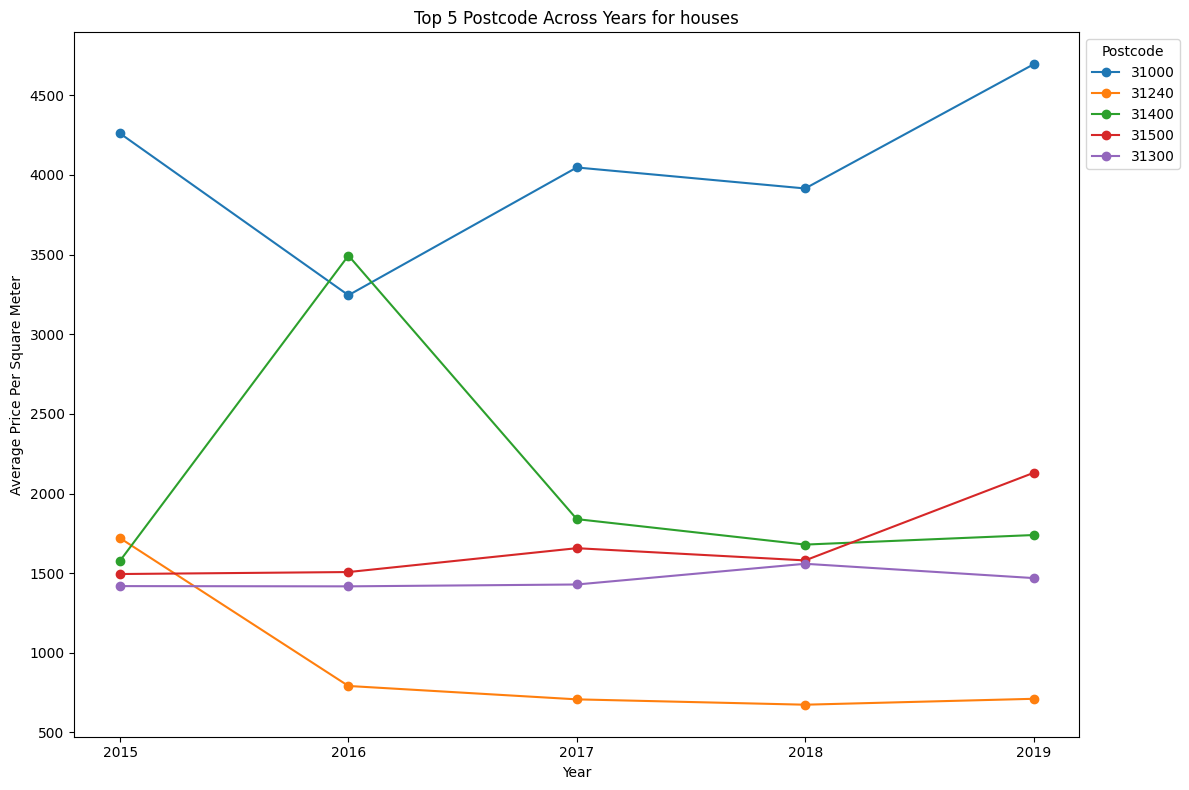

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import substring

# Filter out None values in years
valid_years = [row.Year for row in houses_year.collect() if row.Year is not None]

# Find the range of valid years
min_year = min(valid_years)
max_year = max(valid_years)

# Group by year and PostCode and calculate the average price per square meter
avg_price_per_sqm_year_postcode = houses_year.groupBy("Year", "PostCode").avg("PricePerSqMeter")

# Sort the data by Year and average price per square meter in descending order
sorted_avg_price_per_sqm_year_postcode = avg_price_per_sqm_year_postcode.orderBy("Year", "avg(PricePerSqMeter)", ascending=False)

# Create a list to store top 5 postcodes for each year
top_postcodes_by_year = []

# Iterate over each year to find the top 5 postcodes
for year in range(min_year, max_year + 1):
    # Select top 5 postcodes for the current year
    top_postcodes = sorted_avg_price_per_sqm_year_postcode.filter(sorted_avg_price_per_sqm_year_postcode["Year"] == year) \
        .orderBy("avg(PricePerSqMeter)", ascending=False) \
        .limit(5) \
        .select("PostCode") \
        .rdd.flatMap(lambda x: x).collect()
    top_postcodes_by_year.append(top_postcodes)

plt.figure(figsize=(12, 8))

# Plotting the average price per square meter for each postcode
for i, postcode in enumerate(top_postcodes_by_year[0]):  # Using the postcodes from the first year for consistency
    avg_prices_per_sq_meter = []
    for year in range(min_year, max_year + 1):
        avg_price = avg_price_per_sqm_year_postcode.filter((avg_price_per_sqm_year_postcode["Year"] == year) & (avg_price_per_sqm_year_postcode["PostCode"] == postcode)).collect()
        if avg_price:
            avg_prices_per_sq_meter.append(avg_price[0]["avg(PricePerSqMeter)"])
        else:
            avg_prices_per_sq_meter.append(None)
    plt.plot(range(min_year, max_year + 1), avg_prices_per_sq_meter, marker='o', label=str(postcode))

plt.title('Top 5 Postcode Across Years for houses')
plt.xlabel('Year')
plt.ylabel('Average Price Per Square Meter')
plt.xticks(range(min_year, max_year + 1))
plt.legend(title='Postcode', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()



For Apartment

+--------+--------------------+
|PostCode|avg(PricePerSqMeter)|
+--------+--------------------+
|   31400|  22323.380059533574|
|   31100|  20847.980459397866|
|   31300|  13925.717410471525|
|   31270|  11541.471487764398|
|   31500|   11370.64177038219|
|   31140|  10651.709807646346|
|   31700|   9051.176956767069|
|   31000|   8721.906493357686|
|   31200|   8375.292606104667|
|   31520|  8078.5330840044635|
|   31770|    7877.56260950942|
|   31600|   7717.693642026942|
|   31170|   6030.439058117998|
|   31670|   4279.987884045257|
|   31240|    4000.07608288499|
|   31320|   3952.063429386743|
|   31650|  3364.0620736246065|
|   31130|  3307.6610978092167|
|   31820|   3226.379831424579|
|   31120|  2958.8143588618336|
+--------+--------------------+
only showing top 20 rows



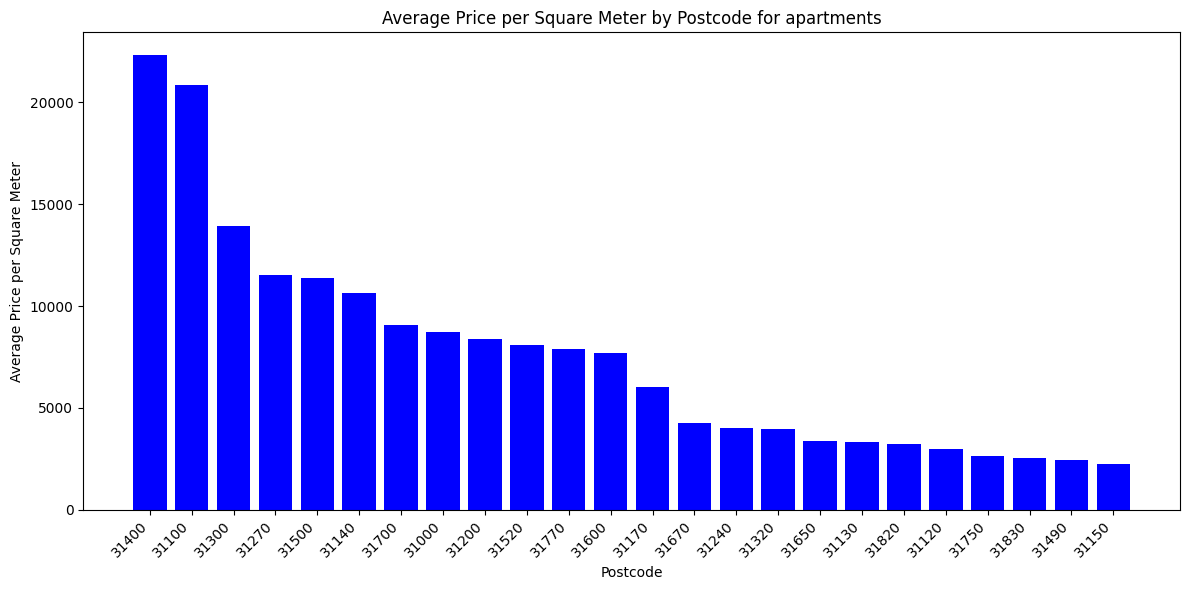

In [ ]:
postcode_apdf=apartments_sqm.groupBy('PostCode').avg('PricePerSqMeter')

sorted_postcode_apdf = postcode_apdf.orderBy('avg(PricePerSqMeter)', ascending=False)
sorted_postcode_apdf.show()

#plotting
import matplotlib.pyplot as plt

postcodes = [row.PostCode for row in sorted_postcode_apdf.collect()]
avg_apprice_per_sq_meter = [row["avg(PricePerSqMeter)"] for row in sorted_postcode_apdf.collect()]

plt.figure(figsize=(12, 6))
plt.bar(postcodes, avg_apprice_per_sq_meter, color='blue')
plt.title('Average Price per Square Meter by Postcode for apartments')
plt.xlabel('Postcode')
plt.ylabel('Average Price per Square Meter')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




The postcode 31400 has the highest average price per square meter for apartments followed by post code 31100. From 31300, the price decreases gradually.

**Plotting Top 5 post code across each year**

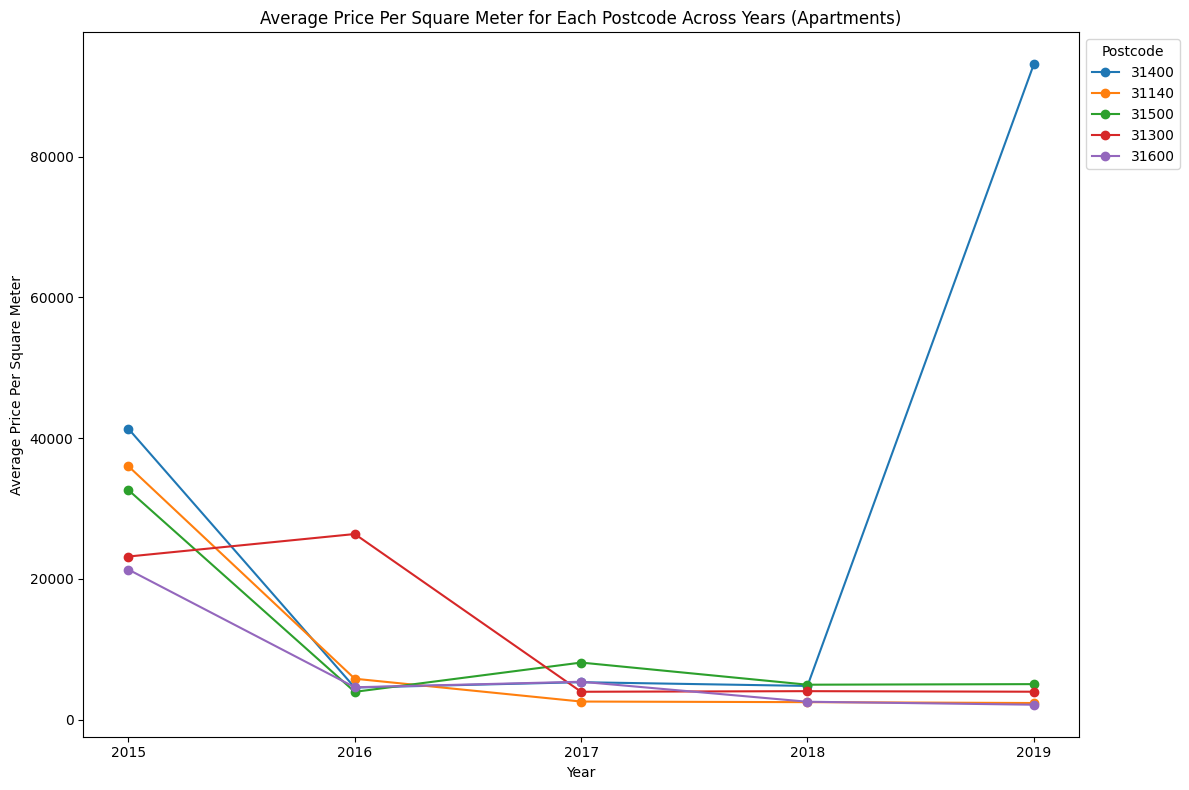

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import substring

# Filter out None values in years
valid_years = [row.Year for row in apartments_year.collect() if row.Year is not None]

# Find the range of valid years
min_year = min(valid_years)
max_year = max(valid_years)

# Group by year and PostCode and calculate the average price per square meter
avg_price_per_sqm_year_postcode = apartments_year.groupBy("Year", "PostCode").avg("PricePerSqMeter")

# Sort the data by Year and average price per square meter in descending order
sorted_avg_price_per_sqm_year_postcode = avg_price_per_sqm_year_postcode.orderBy("Year", "avg(PricePerSqMeter)", ascending=False)

# Create a list to store top 5 postcodes for each year
top_postcodes_by_year = []

# Iterate over each year to find the top 5 postcodes
for year in range(min_year, max_year + 1):
    # Select top 5 postcodes for the current year
    top_postcodes = sorted_avg_price_per_sqm_year_postcode.filter(sorted_avg_price_per_sqm_year_postcode["Year"] == year) \
        .orderBy("avg(PricePerSqMeter)", ascending=False) \
        .limit(5) \
        .select("PostCode") \
        .rdd.flatMap(lambda x: x).collect()
    top_postcodes_by_year.append(top_postcodes)

plt.figure(figsize=(12, 8))

# Plotting the average price per square meter for each postcode
for i, postcode in enumerate(top_postcodes_by_year[0]):  # Using the postcodes from the first year for consistency
    avg_prices_per_sq_meter = []
    for year in range(min_year, max_year + 1):
        avg_price = avg_price_per_sqm_year_postcode.filter((avg_price_per_sqm_year_postcode["Year"] == year) & (avg_price_per_sqm_year_postcode["PostCode"] == postcode)).collect()
        if avg_price:
            avg_prices_per_sq_meter.append(avg_price[0]["avg(PricePerSqMeter)"])
        else:
            avg_prices_per_sq_meter.append(None)
    plt.plot(range(min_year, max_year + 1), avg_prices_per_sq_meter, marker='o', label=str(postcode))

plt.title('Average Price Per Square Meter for Each Postcode Across Years (Apartments)')
plt.xlabel('Year')
plt.ylabel('Average Price Per Square Meter')
plt.xticks(range(min_year, max_year + 1))
plt.legend(title='Postcode', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


#3.  Difference between apartments and houses

For houses

In [ ]:
from pyspark.sql import functions as F

# Grouping by NbRooms and calculating summary statistics
grouped_house_sqm = house_sqm.groupBy("NbRooms").agg(
    F.count("NbRooms").alias("Totalhouses"),
    F.avg("PricePerSqMeter").alias("AvgPricePerSqMeter"),
    F.min("PricePerSqMeter").alias("MinPricePerSqMeter"),
    F.max("PricePerSqMeter").alias("MaxPricePerSqMeter")
)
#sorting by NbRooms(totalhouses)

grouped_house_sqm = grouped_house_sqm.orderBy("Totalhouses", ascending=False)
grouped_house_sqm.show()

+-------+-----------+------------------+--------------------+------------------+
|NbRooms|Totalhouses|AvgPricePerSqMeter|  MinPricePerSqMeter|MaxPricePerSqMeter|
+-------+-----------+------------------+--------------------+------------------+
|      4|       7272|1057.2406475774787|3.450655624568668E-4|          409999.0|
|      5|       4713| 983.2314396486148| 0.09090909090909091|          311150.0|
|      3|       2305|1316.5789035433963|0.004366812227074236| 34233.23241590214|
|      6|       1736| 894.2619185729561|   16.25207296849088| 8396.770472895041|
|      7|        663| 984.1682185587307|                 0.0|11375.348837209302|
|      2|        441|1563.0180816928737|   25.77319587628866|           28850.0|
|      8|        217| 1081.574241148871|  59.642147117296226| 7590.740740740741|
|      1|        162|1347.5098273030785|0.002702702702702703| 8858.695652173914|
|      9|         75|1355.1461650363692|  38.180805126062126| 7929.353448275862|
|     10|         26|1903.89

4 room houses are the most common with 7272 houses followed by 5 room houses with 4713 houses.

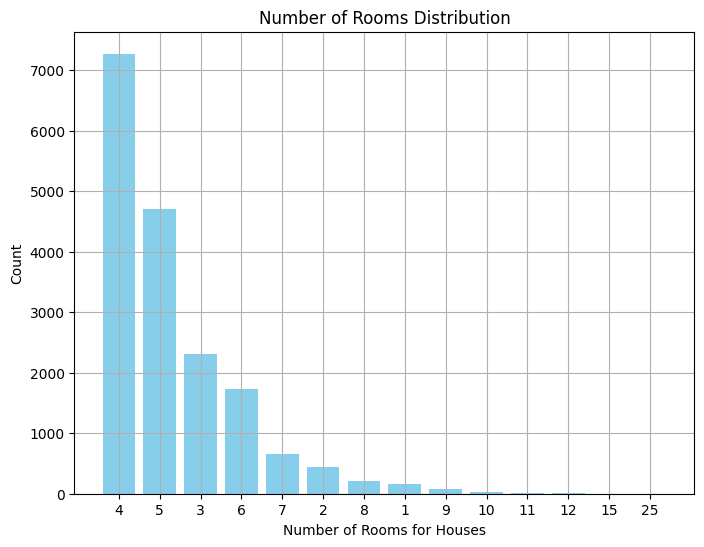

In [ ]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame for plotting
grouped_house_sqm_pd = grouped_house_sqm.toPandas()

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(grouped_house_sqm_pd['NbRooms'], grouped_house_sqm_pd['Totalhouses'], color='skyblue')
plt.title('Number of Rooms Distribution')
plt.xlabel('Number of Rooms for Houses')
plt.ylabel('Count')
plt.grid(True)
plt.show()


Houses with 4,5,3 rooms are mostly preferred as this contribute 81% of the total houses sold over the years.

**Total Number of houses sold in each post code for houses**

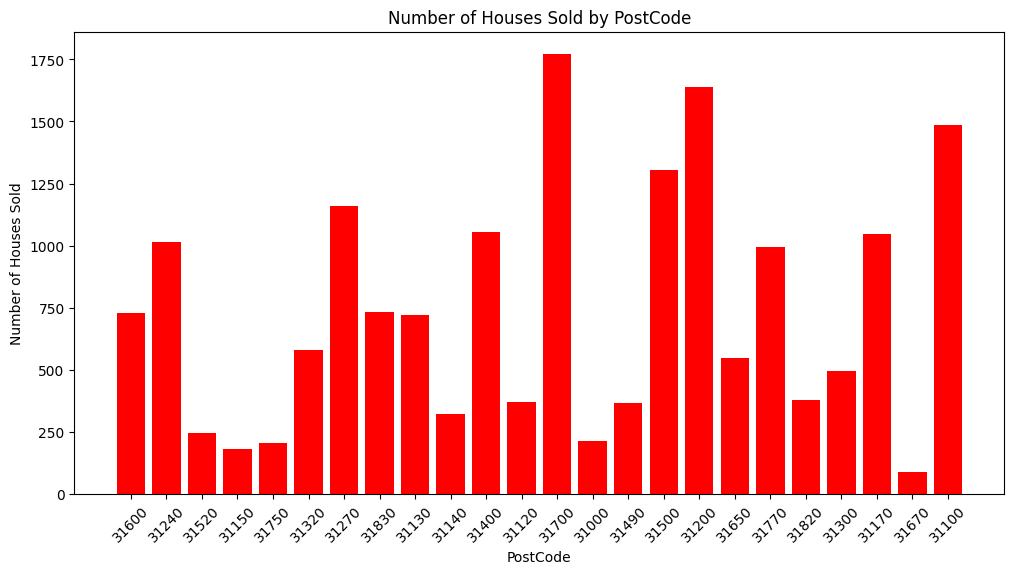

In [ ]:
from pyspark.sql import functions as F

# Grouping by PostCode and counting the number of houses sold
houses_sold_by_postcode = house_sqm.groupBy("PostCode").agg(
    F.count("PostCode").alias("NumHousesSold")
)

# Plotting
houses_sold_by_postcode_pd = houses_sold_by_postcode.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(houses_sold_by_postcode_pd['PostCode'], houses_sold_by_postcode_pd['NumHousesSold'], color='red')
plt.title('Number of Houses Sold by PostCode')
plt.xlabel('PostCode')
plt.ylabel('Number of Houses Sold')
plt.xticks(rotation=45)
plt.show()


The number of houses sold varies across different pincode.several factors could affect the sales across the post codes such as demand, price , transportation etc..,

**Calculating the Correlation between price per square meter and number of house sold for houses**

In [ ]:
# Joining on the PostCode column
housecr_df = houses_sold_by_postcode.join(postcode_df, "PostCode")

# Correlation
correlation = housecr_df.stat.corr("NumHousesSold", "avg(PricePerSqMeter)")
print(f"The correlation coefficient is: {correlation}")


The correlation coefficient is: 0.03377711291461641


The correlation co-efficient 0.03377 indicates a very weak positive relationship between number of houses sold and average price per square meter.This suggest that there is no association between houses sold and average price per square meter.

For apartments

In [ ]:
from pyspark.sql import functions as F

# Grouping by NbRooms and calculating summary statistics
grouped_apartments_sqm = apartments_sqm.groupBy("NbRooms").agg(
    F.count("NbRooms").alias("Totalhouses"),
    F.avg("PricePerSqMeter").alias("AvgPricePerSqMeter"),
    F.min("PricePerSqMeter").alias("MinPricePerSqMeter"),
    F.max("PricePerSqMeter").alias("MaxPricePerSqMeter")
)
#sorting

grouped_apartments_sqm = grouped_apartments_sqm.orderBy("Totalhouses", ascending=False)
grouped_apartments_sqm.show()

+-------+-----------+------------------+--------------------+------------------+
|NbRooms|Totalhouses|AvgPricePerSqMeter|  MinPricePerSqMeter|MaxPricePerSqMeter|
+-------+-----------+------------------+--------------------+------------------+
|      3|      21323|10927.244724204967|                 0.0| 655435.6470588235|
|      2|      20237|10666.394305796184|                 0.0|          815298.0|
|      1|       9704| 20388.78367988984|0.018518518518518517|        1392800.75|
|      4|       9030| 8900.547660940218|0.007407407407407408|          759709.5|
|      5|       1871| 5371.535684479946|0.004329004329004329| 355608.7021276596|
|      6|        230| 4574.038277871004|0.006535947712418301| 82857.14285714286|
|      7|         48| 4306.774022194607|   715.8273381294964|           17500.0|
|      8|         19|3605.6180887106175|   608.3650190114068| 8227.848101265823|
|     10|         13|1459.3716410866853|  1074.6268656716418| 1917.910447761194|
|      9|          9|2485.03

3 room apartments are most sold with 21323 followed by 2 rooms with 20237.

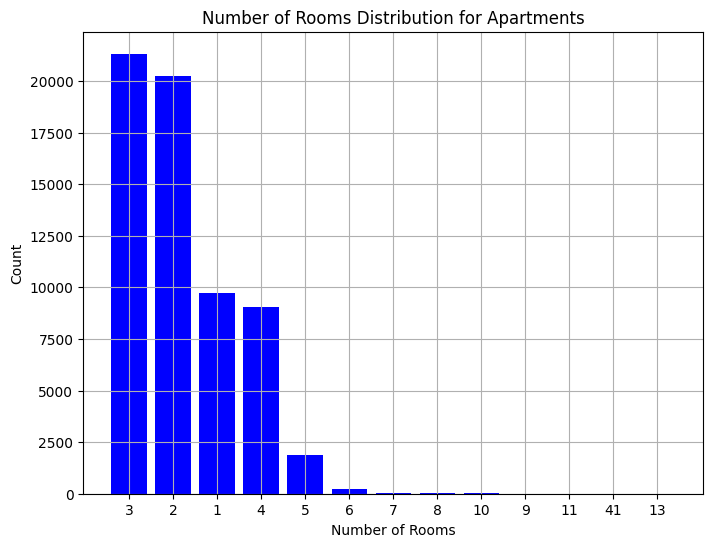

In [ ]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame for plotting
grouped_apartments_sqm_pd = grouped_apartments_sqm.toPandas()

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(grouped_apartments_sqm_pd['NbRooms'], grouped_apartments_sqm_pd['Totalhouses'], color='blue')
plt.title('Number of Rooms Distribution for Apartments')
plt.xlabel('Number of Rooms')
plt.ylabel('Count')
plt.grid(True)
plt.show()


Most prefer apartments with 1,2,3 rooms which contributes to around 82% of the apartments sold.

**Total number of houses sold in each postcode for apartments**

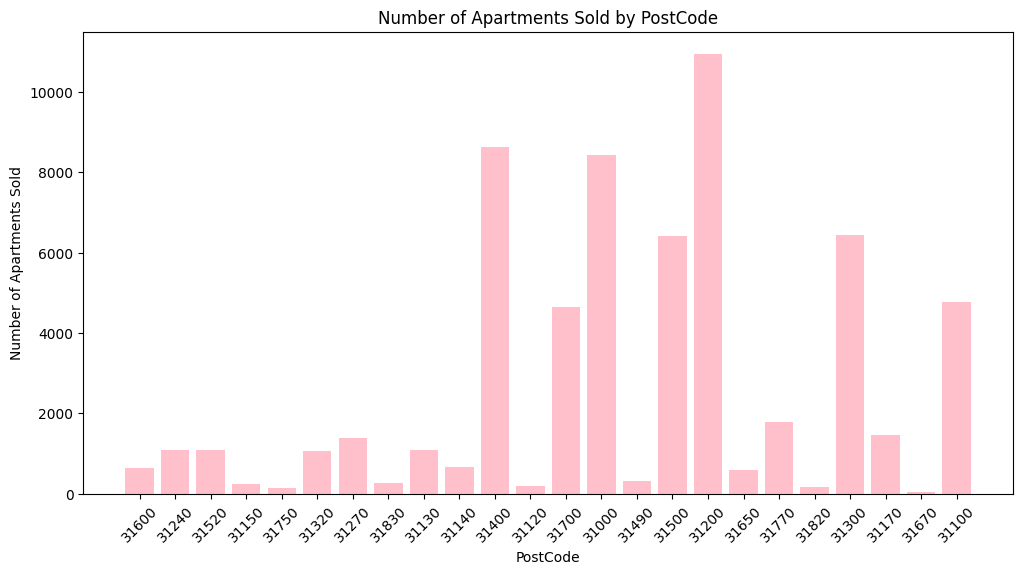

In [ ]:
from pyspark.sql import functions as F

# Grouping by PostCode and counting the number of apartments sold
apartments_sold_by_postcode = apartments_sqm.groupBy("PostCode").agg(
    F.count("PostCode").alias("NumApartmentsSold")
)

# Plotting
apartments_sold_by_postcode_pd = apartments_sold_by_postcode.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(apartments_sold_by_postcode_pd['PostCode'], apartments_sold_by_postcode_pd['NumApartmentsSold'], color='pink')
plt.title('Number of Apartments Sold by PostCode')
plt.xlabel('PostCode')
plt.ylabel('Number of Apartments Sold')
plt.xticks(rotation=45)
plt.show()


Few Post codes liek 31200, 31000 ,31400 have high sales compared with other post codes.This may be due to accessibility, price etc..,

**Calculating the Correlation between price per square meter and number of house sold for Apartments**

In [ ]:
# Joining on the PostCode column
apartmentcr_df = apartments_sold_by_postcode.join(postcode_apdf, "PostCode")

# Correlation
correlation = apartmentcr_df.stat.corr("NumApartmentsSold", "avg(PricePerSqMeter)")
print(f"The correlation coefficient is: {correlation}")


The correlation coefficient is: 0.6477985401056934


The correlation coefficient between the number of apartments sold and the average price per square meter for apartments is approximately 0.648. This suggets a moderately positive correlation between these two variables.

#4. Analysing Sales type for Houses and Apartments

For Houses

In [ ]:
from pyspark.sql.functions import col, avg, min, max, count

# Grouping by SaleType and ResidenceType,Postcode and then performing the aggregations

house_sales_df = house_sqm.groupBy("SaleType", "ResidenceType","PostCode") \
    .agg(
        avg("PricePerSqMeter").alias("AvgPricePerSqMeter"),
        min("PricePerSqMeter").alias("MinPricePerSqMeter"),
        max("PricePerSqMeter").alias("MaxPricePerSqMeter"),
        count("*").alias("NumberOfSales")
    )

#sorting

house_sales_sorted_df = house_sales_df.orderBy("NumberOfSales", ascending=False)
house_sales_sorted_df.show()

+--------+-------------+--------+------------------+--------------------+------------------+-------------+
|SaleType|ResidenceType|PostCode|AvgPricePerSqMeter|  MinPricePerSqMeter|MaxPricePerSqMeter|NumberOfSales|
+--------+-------------+--------+------------------+--------------------+------------------+-------------+
|    SALE|        HOUSE|   31700| 863.6873403061198|   7.545271629778672|20045.454545454544|         1594|
|    SALE|        HOUSE|   31200|1263.2379096414638|0.004366812227074236|          135000.0|         1558|
|    SALE|        HOUSE|   31100| 1032.517680201519|  1.7857142857142858|           52000.0|         1423|
|    SALE|        HOUSE|   31500|1615.9786411281273|                 1.0| 16592.59259259259|         1297|
|    SALE|        HOUSE|   31400| 2083.105718381356|                 1.0|          409999.0|         1039|
|    SALE|        HOUSE|   31270|  705.463516399841|  6.4935064935064934|        13007.1875|         1004|
|    SALE|        HOUSE|   31240| 926

The number of houses sold before completion are significantly lower than completed houses.

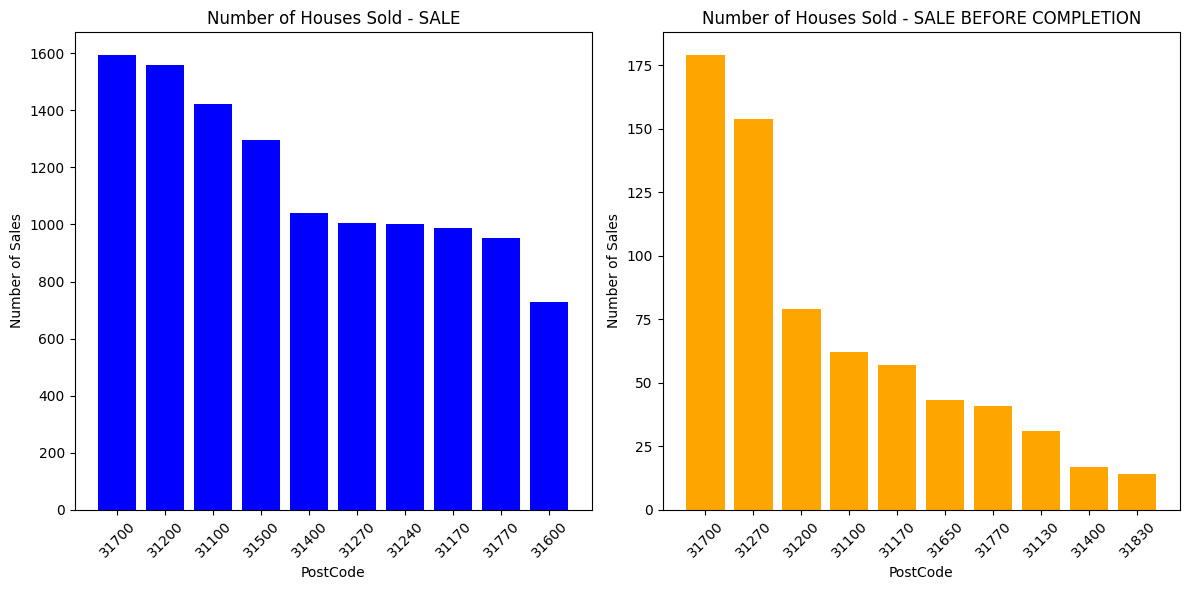

In [ ]:
import matplotlib.pyplot as plt

# Separating by SaleType
house_sale_df = house_sales_sorted_df.filter(house_sales_sorted_df["SaleType"] == "SALE").limit(10)
house_sale_before_completion_df = house_sales_sorted_df.filter(house_sales_sorted_df["SaleType"] == "SALE BEFORE COMPLETION").limit(10)

# Converting PySpark DataFrames to Pandas DataFrames for plotting
house_sale_pd = house_sale_df.toPandas()
house_sale_before_completion_pd = house_sale_before_completion_df.toPandas()

# Plotting
plt.figure(figsize=(12, 6))

#For SALE houses
plt.subplot(1, 2, 1)
plt.bar(house_sale_pd['PostCode'], house_sale_pd['NumberOfSales'], color='blue')
plt.title('Number of Houses Sold - SALE')
plt.xlabel('PostCode')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)

# For SALE BEFORE COMPLETION houses
plt.subplot(1, 2, 2)
plt.bar(house_sale_before_completion_pd['PostCode'], house_sale_before_completion_pd['NumberOfSales'], color='orange')
plt.title('Number of Houses Sold - SALE BEFORE COMPLETION')
plt.xlabel('PostCode')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The sales chart shows a unifrom distribution compared to sales before completion chart.Post codes like 31700,31200,31100 shows a higher number of sales in sales chart. However, 31700 performs well in both sales type.

For Apartments

In [ ]:
from pyspark.sql.functions import col, avg, min, max, count

# Grouping by SaleType and ResidenceType,PostCode and then performing the aggregations

apartments_sales_df = apartments_sqm.groupBy("SaleType", "ResidenceType","PostCode") \
    .agg(
        avg("PricePerSqMeter").alias("AvgPricePerSqMeter"),
        min("PricePerSqMeter").alias("MinPricePerSqMeter"),
        max("PricePerSqMeter").alias("MaxPricePerSqMeter"),
        count("*").alias("NumberOfSales")
    )

#sorting

apartments_sales_sorted_df = apartments_sales_df.orderBy("NumberOfSales", ascending=False)
apartments_sales_sorted_df.show()

+--------------------+-------------+--------+------------------+--------------------+------------------+-------------+
|            SaleType|ResidenceType|PostCode|AvgPricePerSqMeter|  MinPricePerSqMeter|MaxPricePerSqMeter|NumberOfSales|
+--------------------+-------------+--------+------------------+--------------------+------------------+-------------+
|                SALE|    APARTMENT|   31000|  8739.68229115734|                 0.0| 676470.5882352941|         8077|
|                SALE|    APARTMENT|   31200|10258.785181035628|                 0.0| 777377.1627906977|         7744|
|                SALE|    APARTMENT|   31400|24364.468618427803|0.011904761904761904| 795886.1428571428|         7696|
|                SALE|    APARTMENT|   31500|12184.384970623663|  16.666666666666668|        1392800.75|         5711|
|                SALE|    APARTMENT|   31300|15912.827351915721|  21.978021978021978| 722210.7741935484|         5389|
|                SALE|    APARTMENT|   31100| 24

The number of apartments sold before completion are significantly lower than completed houses.

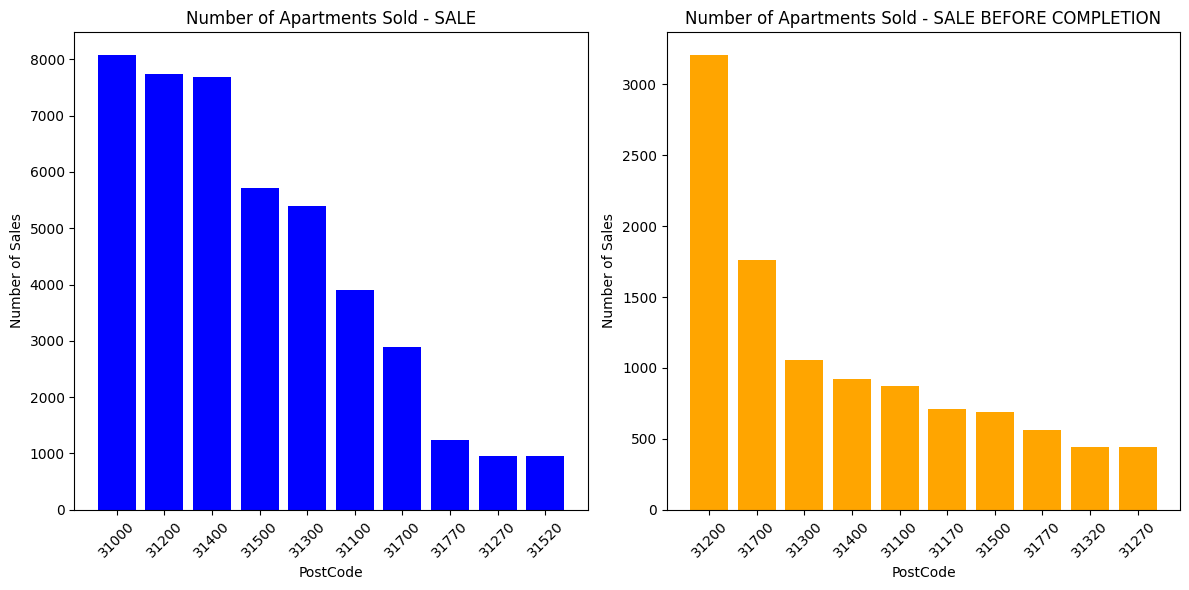

In [ ]:
import matplotlib.pyplot as plt

# Separating by SaleType
ap_sale_df = apartments_sales_sorted_df.filter(apartments_sales_sorted_df["SaleType"] == "SALE").limit(10)
ap_sale_before_completion_df = apartments_sales_sorted_df.filter(apartments_sales_sorted_df["SaleType"] == "SALE BEFORE COMPLETION").limit(10)

# Converting PySpark DataFrames to Pandas DataFrames for plotting
ap_sale_pd = ap_sale_df.toPandas()
ap_sale_before_completion_pd = ap_sale_before_completion_df.toPandas()

# Plotting
plt.figure(figsize=(12, 6))

# For SALE apartments
plt.subplot(1, 2, 1)
plt.bar(ap_sale_pd['PostCode'], ap_sale_pd['NumberOfSales'], color='blue')
plt.title('Number of Apartments Sold - SALE')
plt.xlabel('PostCode')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)

# For SALE BEFORE COMPLETION apartments
plt.subplot(1, 2, 2)
plt.bar(ap_sale_before_completion_pd['PostCode'], ap_sale_before_completion_pd['NumberOfSales'], color='orange')
plt.title('Number of Apartments Sold - SALE BEFORE COMPLETION')
plt.xlabel('PostCode')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The number of apartments sold before completion is less compared with number of apartments sold after completion. The apartemnts sold after completion decreases gradually while the other graph is more steeper. However, 31200 is performing well in both cases.

#5.  Differences between Toulouse and its suburbs

Filtering toulouse

In [ ]:
#filtering
toulouse_df = data.filter(col('City') == 'TOULOUSE')
toulouse_df.show()

count_toulouse = toulouse_df.count()
print(" Toulouse:", count_toulouse)

+----------+--------+------+--------+--------+-------+------+-------------+----------+--------+
|  SaleDate|SaleType| Price|PostCode|    City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------+------+--------+--------+-------+------+-------------+----------+--------+
|03/01/2019|    SALE|380000|   31500|TOULOUSE|      2|     0|        HOUSE|        52|     160|
|07/01/2019|    SALE|128000|   31500|TOULOUSE|      5|     2|    APARTMENT|        78|       0|
|09/01/2019|    SALE|155447|   31500|TOULOUSE|      4|     1|    APARTMENT|        78|       0|
|09/01/2019|    SALE| 72000|   31500|TOULOUSE|      2|     2|    APARTMENT|        39|       0|
|08/01/2019|    SALE|108500|   31400|TOULOUSE|      2|     1|    APARTMENT|        45|       0|
|08/01/2019|    SALE|250000|   31000|TOULOUSE|      2|     2|    APARTMENT|        50|       0|
|03/01/2019|    SALE|100728|   31500|TOULOUSE|      3|     1|    APARTMENT|        63|       0|
|11/01/2019|    SALE| 74000|   31000|TOU

A total of 51797 properties are sold in Toulouse.

In [ ]:
from pyspark.sql import functions as F

# Filtering to separate houses and apartments
houses_tls_df = toulouse_df.filter(F.col('ResidenceType') == 'HOUSE')
apartments_tls_df = toulouse_df.filter(F.col('ResidenceType') == 'APARTMENT')

# Calculating price per square meter
houses_tls_sqm_df = houses_tls_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LandArea'))
apartments_tls_sqm_df = apartments_tls_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LivingArea'))

# Results
print("Houses Prices per Square Meter:")
houses_tls_sqm_df.show()

print("Apartments Prices per Square Meter:")
apartments_tls_sqm_df.show()


Houses Prices per Square Meter:
+----------+--------+------+--------+--------+-------+------+-------------+----------+--------+------------------+
|  SaleDate|SaleType| Price|PostCode|    City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|   PricePerSqMeter|
+----------+--------+------+--------+--------+-------+------+-------------+----------+--------+------------------+
|03/01/2019|    SALE|380000|   31500|TOULOUSE|      2|     0|        HOUSE|        52|     160|            2375.0|
|08/01/2019|    SALE|215000|   31200|TOULOUSE|      4|     0|        HOUSE|        89|     274| 784.6715328467153|
|02/01/2019|    SALE|337700|   31500|TOULOUSE|      4|     0|        HOUSE|        70|     383| 881.7232375979112|
|04/01/2019|    SALE|336700|   31500|TOULOUSE|      4|     0|        HOUSE|        63|     217|1551.6129032258063|
|04/01/2019|    SALE|420000|   31400|TOULOUSE|      4|     0|        HOUSE|       100|     248|1693.5483870967741|
|14/01/2019|    SALE|575600|   31500|TOULOUSE|  

**Seperating based on sale type and calculating price per sq meter for apartments and houses**

In [ ]:
from pyspark.sql import functions as F

# Separating houses and apartments  on sales type 'SALE'
houses_sale_df = houses_tls_df.filter(F.col('SaleType') == 'SALE')
apartments_sale_df = apartments_tls_df.filter(F.col('SaleType') == 'SALE')

# Separating houses and apartments  on sales type 'SALE BEFORE COMPLETION'
houses_before_completion_df = houses_tls_df.filter(F.col('SaleType') == 'SALE BEFORE COMPLETION')
apartments_before_completion_df = apartments_tls_df.filter(F.col('SaleType') == 'SALE BEFORE COMPLETION')

# Calculate price per square meter
houses_sale_sqm_df = houses_sale_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LandArea'))
apartments_sale_sqm_df = apartments_sale_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LivingArea'))

houses_before_completion_sqm_df = houses_before_completion_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LandArea'))
apartments_before_completion_sqm_df = apartments_before_completion_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LivingArea'))

# Results
print("House Prices per Square Meter - SALE:")
houses_sale_sqm_df.show(5)

print("Apartment Prices per Square Meter - SALE:")
apartments_sale_sqm_df.show(5)

print("House Prices per Square Meter - SALE BEFORE COMPLETION:")
houses_before_completion_sqm_df.show(5)

print("Apartment Prices per Square Meter - SALE BEFORE COMPLETION:")
apartments_before_completion_sqm_df.show(5)


House Prices per Square Meter - SALE:
+----------+--------+------+--------+--------+-------+------+-------------+----------+--------+------------------+
|  SaleDate|SaleType| Price|PostCode|    City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|   PricePerSqMeter|
+----------+--------+------+--------+--------+-------+------+-------------+----------+--------+------------------+
|03/01/2019|    SALE|380000|   31500|TOULOUSE|      2|     0|        HOUSE|        52|     160|            2375.0|
|08/01/2019|    SALE|215000|   31200|TOULOUSE|      4|     0|        HOUSE|        89|     274| 784.6715328467153|
|02/01/2019|    SALE|337700|   31500|TOULOUSE|      4|     0|        HOUSE|        70|     383| 881.7232375979112|
|04/01/2019|    SALE|336700|   31500|TOULOUSE|      4|     0|        HOUSE|        63|     217|1551.6129032258063|
|04/01/2019|    SALE|420000|   31400|TOULOUSE|      4|     0|        HOUSE|       100|     248|1693.5483870967741|
+----------+--------+------+--------+-----

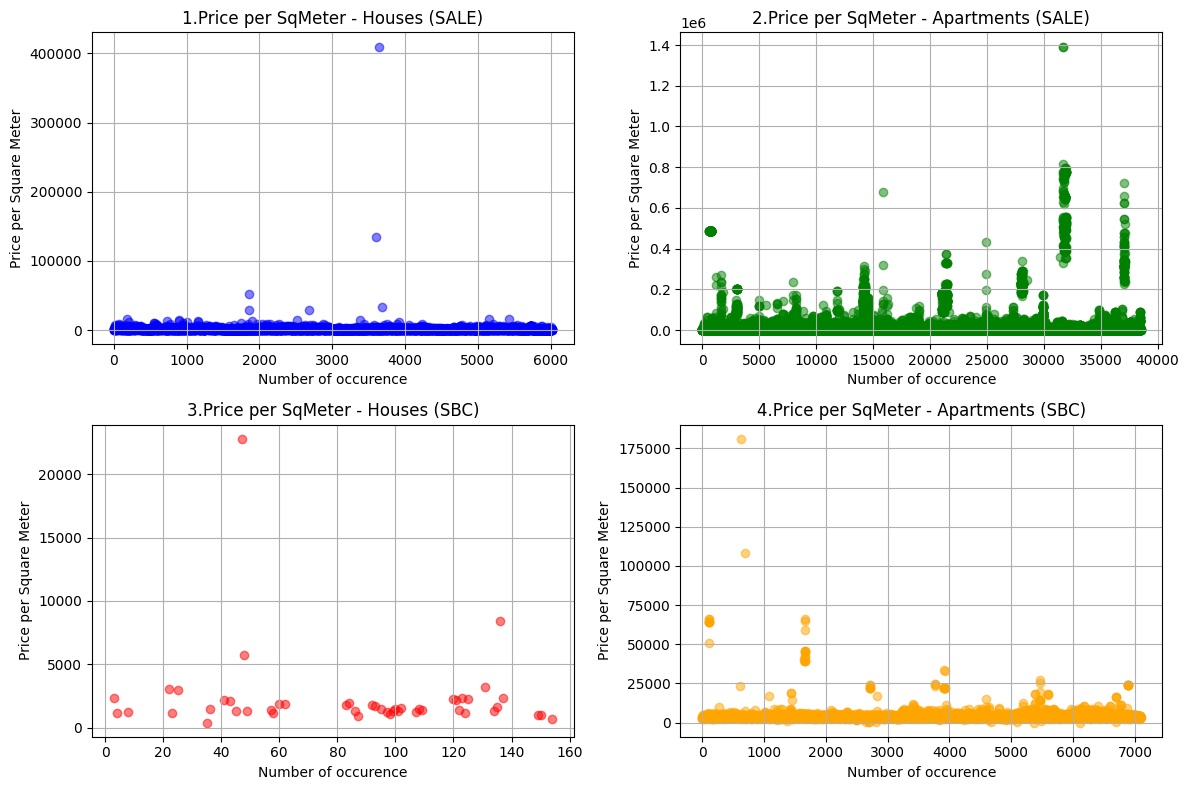

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrames to Pandas DataFrames for plotting
houses_sale_pd = houses_sale_sqm_df.select('PricePerSqMeter').toPandas()
apartments_sale_pd = apartments_sale_sqm_df.select('PricePerSqMeter').toPandas()
houses_before_completion_pd = houses_before_completion_sqm_df.select('PricePerSqMeter').toPandas()
apartments_before_completion_pd = apartments_before_completion_sqm_df.select('PricePerSqMeter').toPandas()

# Plotting
plt.figure(figsize=(12, 8))

# Plot for 'SALE' houses and apartments
plt.subplot(2, 2, 1)
plt.scatter(range(len(houses_sale_pd)), houses_sale_pd['PricePerSqMeter'], color='blue', alpha=0.5)
plt.title('1.Price per SqMeter - Houses (SALE)')
plt.xlabel('Number of occurence')
plt.ylabel('Price per Square Meter')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.scatter(range(len(apartments_sale_pd)), apartments_sale_pd['PricePerSqMeter'], color='green', alpha=0.5)
plt.title('2.Price per SqMeter - Apartments (SALE)')
plt.xlabel('Number of occurence')
plt.ylabel('Price per Square Meter')
plt.grid(True)

# Plot for 'SALE BEFORE COMPLETION' houses and apartments
plt.subplot(2, 2, 3)
plt.scatter(range(len(houses_before_completion_pd)), houses_before_completion_pd['PricePerSqMeter'], color='red', alpha=0.5)
plt.title('3.Price per SqMeter - Houses (SBC)')
plt.xlabel('Number of occurence')
plt.ylabel('Price per Square Meter')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.scatter(range(len(apartments_before_completion_pd)), apartments_before_completion_pd['PricePerSqMeter'], color='orange', alpha=0.5)
plt.title('4.Price per SqMeter - Apartments (SBC)')
plt.xlabel('Number of occurence')
plt.ylabel('Price per Square Meter')
plt.grid(True)

plt.tight_layout()
plt.show()





1.   Most of the house sales are clustered near the X -axis, indicating that house have low price per sq meter.
2.  The apartment sales are also clustered at the bottom axis, indicating that apartments have low price per square meter.
3. Incase of houses sold before completion, there only few occurences, which suggests customers perfer completed houses.
4. When compared with (3) more apartments are sold before completion.Most of the points are concnetrated in the bottom axis.



**Grouping by NbRooms for each sales type**

In [ ]:
from pyspark.sql import functions as F

# Group by NbRooms and count for each sales type
houses_sale_count_by_rooms = houses_sale_sqm_df.groupBy('NbRooms').count().orderBy('count')
apartments_sale_count_by_rooms = apartments_sale_sqm_df.groupBy('NbRooms').count().orderBy('count')
houses_before_completion_count_by_rooms = houses_before_completion_sqm_df.groupBy('NbRooms').count().orderBy('count')
apartments_before_completion_count_by_rooms = apartments_before_completion_sqm_df.groupBy('NbRooms').count().orderBy('count')

# Display the results
print("House Prices per Square Meter - SALE:")
houses_sale_count_by_rooms.show()

print("Apartment Prices per Square Meter - SALE:")
apartments_sale_count_by_rooms.show()

print("House Prices per Square Meter - SALE BEFORE COMPLETION:")
houses_before_completion_count_by_rooms.show()

print("Apartment Prices per Square Meter - SALE BEFORE COMPLETION:")
apartments_before_completion_count_by_rooms.show()


House Prices per Square Meter - SALE:
+-------+-----+
|NbRooms|count|
+-------+-----+
|     25|    1|
|     12|    5|
|     10|    8|
|     11|    9|
|      9|   33|
|      1|   84|
|      8|  103|
|      7|  236|
|      2|  260|
|      6|  557|
|      3| 1053|
|      5| 1449|
|      4| 2224|
+-------+-----+

Apartment Prices per Square Meter - SALE:
+-------+-----+
|NbRooms|count|
+-------+-----+
|     11|    1|
|     13|    1|
|      9|    7|
|     10|   13|
|      8|   19|
|      7|   41|
|      6|  194|
|      5| 1436|
|      4| 6115|
|      1| 7827|
|      2|10972|
|      3|11887|
+-------+-----+

House Prices per Square Meter - SALE BEFORE COMPLETION:
+-------+-----+
|NbRooms|count|
+-------+-----+
|      6|    2|
|      5|   16|
|      3|   62|
|      4|   89|
+-------+-----+

Apartment Prices per Square Meter - SALE BEFORE COMPLETION:
+-------+-----+
|NbRooms|count|
+-------+-----+
|     11|    1|
|     41|    1|
|      9|    2|
|      7|    2|
|      5|   62|
|      4|  423|
|

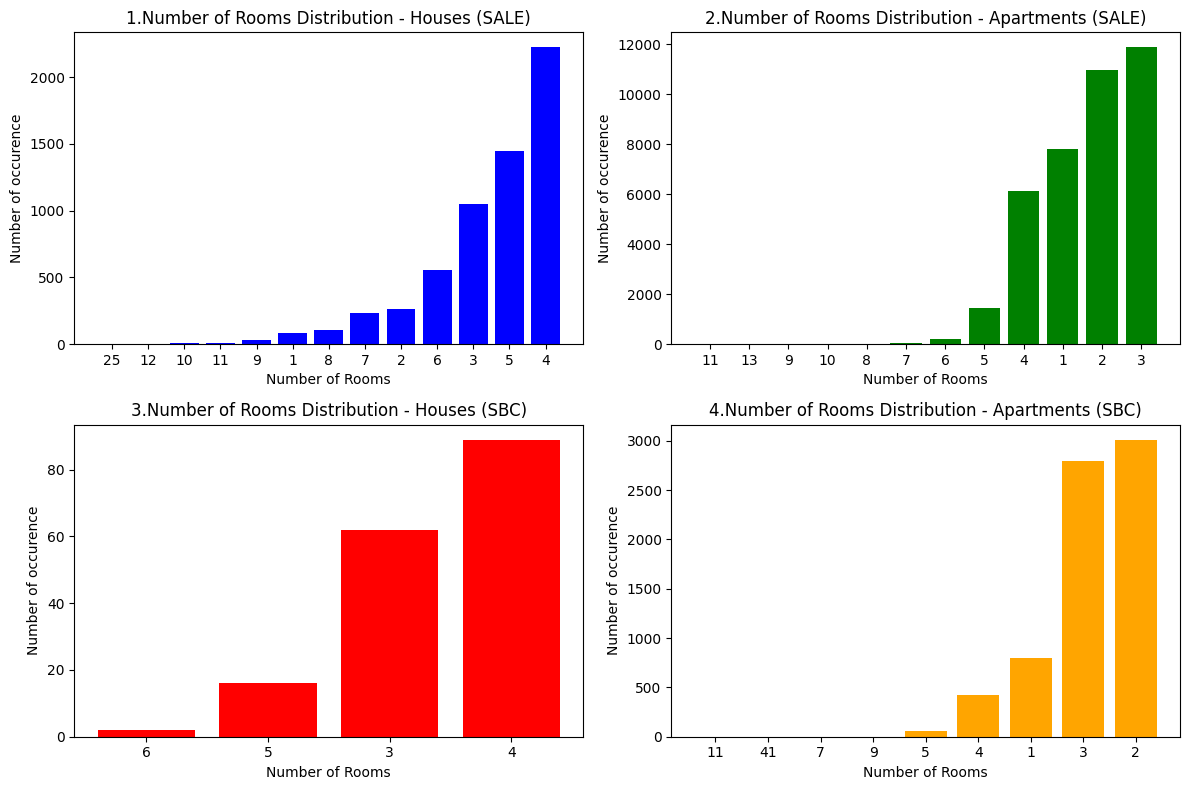

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrames to Pandas DataFrames for plotting
houses_sale_count_pd = houses_sale_count_by_rooms.toPandas()
apartments_sale_count_pd = apartments_sale_count_by_rooms.toPandas()
houses_before_completion_count_pd = houses_before_completion_count_by_rooms.toPandas()
apartments_before_completion_count_pd = apartments_before_completion_count_by_rooms.toPandas()

# Plotting
plt.figure(figsize=(12, 8))

# Plot for 'SALE' houses
plt.subplot(2, 2, 1)
plt.bar(houses_sale_count_pd['NbRooms'], houses_sale_count_pd['count'], color='blue')
plt.title('1.Number of Rooms Distribution - Houses (SALE)')
plt.xlabel('Number of Rooms')
plt.ylabel('Number of occurence')

# Plot for 'SALE' apartments
plt.subplot(2, 2, 2)
plt.bar(apartments_sale_count_pd['NbRooms'], apartments_sale_count_pd['count'], color='green')
plt.title('2.Number of Rooms Distribution - Apartments (SALE)')
plt.xlabel('Number of Rooms')
plt.ylabel('Number of occurence')

# Plot for 'SALE BEFORE COMPLETION' houses
plt.subplot(2, 2, 3)
plt.bar(houses_before_completion_count_pd['NbRooms'], houses_before_completion_count_pd['count'], color='red')
plt.title('3.Number of Rooms Distribution - Houses (SBC)')
plt.xlabel('Number of Rooms')
plt.ylabel('Number of occurence')

# Plot for 'SALE BEFORE COMPLETION' apartments
plt.subplot(2, 2, 4)
plt.bar(apartments_before_completion_count_pd['NbRooms'], apartments_before_completion_count_pd['count'], color='orange')
plt.title('4.Number of Rooms Distribution - Apartments (SBC)')
plt.xlabel('Number of Rooms')
plt.ylabel('Number of occurence')

plt.tight_layout()
plt.show()


1. 4-room houses are the most commonly sold, followed by 3-room houses.The frequency decreases as the number of rooms increases.
2. 3-room apartments have the highest occurrence,followed by 2 rooms. Decreasing trens is observed.
3. 4-room houses are the most common for sales before completion.
4. 2-room apartments are the most frequently sold before completion, followed by 3-room apartments.


For Suburbs

In [ ]:
suburbs_df = data.filter(col('City') != 'TOULOUSE')
suburbs_df.show()

count_suburbs=suburbs_df.count()
print(" suburbs:", count_suburbs)

+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|            SaleType|    Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+
|15/01/2019|                SALE|    95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|21/01/2019|                SALE|   261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|03/01/2019|                SALE|   101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|11/01/2019|                SALE|    59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|15/01/2019|                SALE|   179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
|15/01/2019|            

In [ ]:
suburbs_df = data.filter(F.col('City') != 'TOULOUSE')
suburbs_df.show()

count_suburbs = suburbs_df.count()
print("Suburbs:", count_suburbs)

from pyspark.sql import functions as F

# Filter DataFrame to separate houses and apartments for suburbs
houses_suburbs_df = suburbs_df.filter(F.col('ResidenceType') == 'HOUSE')
apartments_suburbs_df = suburbs_df.filter(F.col('ResidenceType') == 'APARTMENT')

# Calculate price per square meter for suburbs
houses_suburbs_sqm_df = houses_suburbs_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LandArea'))
apartments_suburbs_sqm_df = apartments_suburbs_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LivingArea'))

# Display the results
print("Houses Prices per Square Meter for Suburbs:")
houses_suburbs_sqm_df.show()

print("Apartments Prices per Square Meter for Suburbs:")
apartments_suburbs_sqm_df.show()


+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|            SaleType|    Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+
|15/01/2019|                SALE|    95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|21/01/2019|                SALE|   261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|03/01/2019|                SALE|   101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|11/01/2019|                SALE|    59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|15/01/2019|                SALE|   179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
|15/01/2019|            

**Seperating based on sales type and calculating price per sq meter for houses and apartments**

In [ ]:
from pyspark.sql import functions as F

# Separate houses and apartments based on sales type 'SALE' for suburbs
houses_sale_suburbs_df = houses_suburbs_df.filter(F.col('SaleType') == 'SALE')
apartments_sale_suburbs_df = apartments_suburbs_df.filter(F.col('SaleType') == 'SALE')

# Separate houses and apartments based on sales type 'SALE BEFORE COMPLETION' for suburbs
houses_before_completion_suburbs_df = houses_suburbs_df.filter(F.col('SaleType') == 'SALE BEFORE COMPLETION')
apartments_before_completion_suburbs_df = apartments_suburbs_df.filter(F.col('SaleType') == 'SALE BEFORE COMPLETION')

# Calculate price per square meter for each category for suburbs
houses_sale_suburbs_sqm_df = houses_sale_suburbs_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LandArea'))
apartments_sale_suburbs_sqm_df = apartments_sale_suburbs_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LivingArea'))

houses_before_completion_suburbs_sqm_df = houses_before_completion_suburbs_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LandArea'))
apartments_before_completion_suburbs_sqm_df = apartments_before_completion_suburbs_df.withColumn('PricePerSqMeter', F.col('Price') / F.col('LivingArea'))

# Display the results
print("House Prices per Square Meter - SALE (Suburbs):")
houses_sale_suburbs_sqm_df.show(5)

print("Apartment Prices per Square Meter - SALE (Suburbs):")
apartments_sale_suburbs_sqm_df.show(5)

print("House Prices per Square Meter - SALE BEFORE COMPLETION (Suburbs):")
houses_before_completion_suburbs_sqm_df.show(5)

print("Apartment Prices per Square Meter - SALE BEFORE COMPLETION (Suburbs):")
apartments_before_completion_suburbs_sqm_df.show(5)


House Prices per Square Meter - SALE (Suburbs):
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+------------------+
|  SaleDate|SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|   PricePerSqMeter|
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+------------------+
|15/01/2019|    SALE| 95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|188.11881188118812|
|21/01/2019|    SALE|261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311| 841.4790996784566|
|15/01/2019|    SALE|179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263| 680.6083650190114|
|15/01/2019|    SALE|209300|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        74|     257| 814.3968871595331|
|18/01/2019|    SALE|228000|   31270|VILLENEUVE TOLOSANE|      4|     

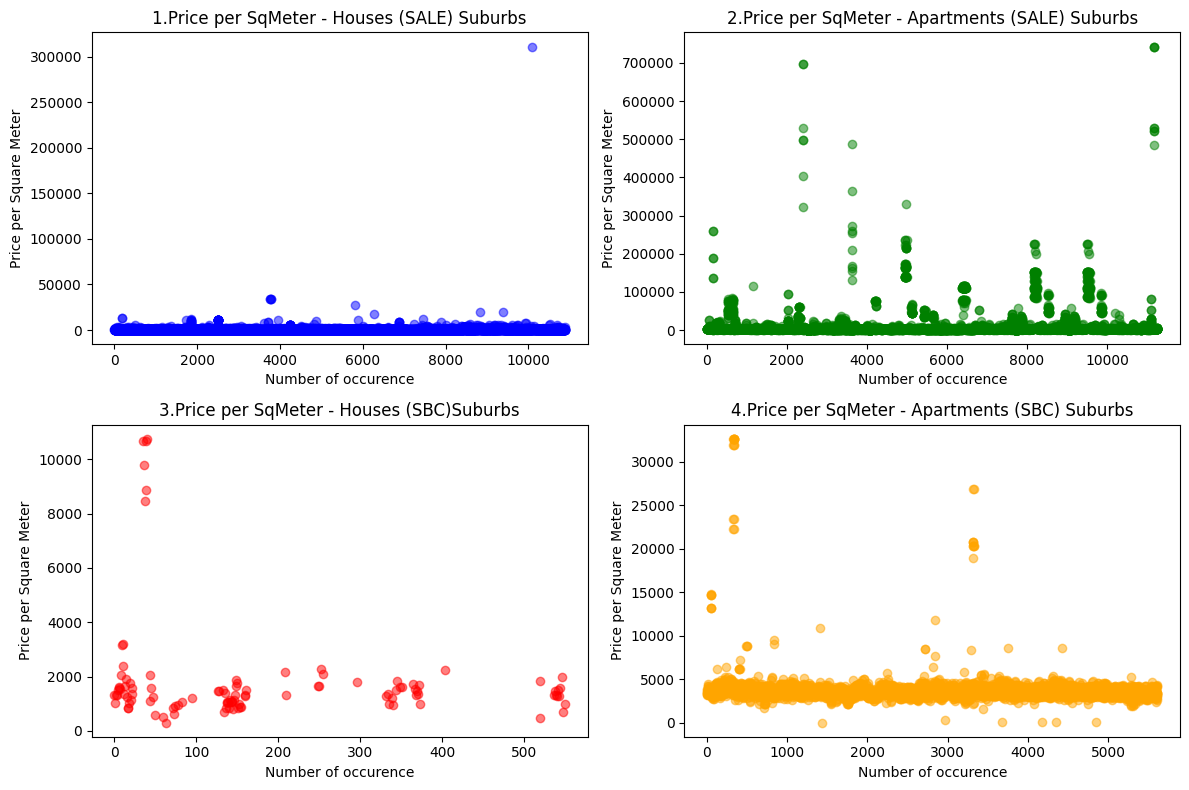

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrames to Pandas DataFrames for plotting
houses_sale_suburbs_pd = houses_sale_suburbs_sqm_df.select('PricePerSqMeter').toPandas()
apartments_sale_suburbs_pd = apartments_sale_suburbs_sqm_df.select('PricePerSqMeter').toPandas()
houses_before_completion_suburbs_pd = houses_before_completion_suburbs_sqm_df.select('PricePerSqMeter').toPandas()
apartments_before_completion_suburbs_pd = apartments_before_completion_suburbs_sqm_df.select('PricePerSqMeter').toPandas()

# Plotting
plt.figure(figsize=(12, 8))

# Plot for 'SALE' houses and apartments in suburbs
plt.subplot(2, 2, 1)
plt.scatter(range(len(houses_sale_suburbs_pd)), houses_sale_suburbs_pd['PricePerSqMeter'], color='blue', alpha=0.5)
plt.title('1.Price per SqMeter - Houses (SALE) Suburbs')
plt.xlabel('Number of occurence')
plt.ylabel('Price per Square Meter')

plt.subplot(2, 2, 2)
plt.scatter(range(len(apartments_sale_suburbs_pd)), apartments_sale_suburbs_pd['PricePerSqMeter'], color='green', alpha=0.5)
plt.title('2.Price per SqMeter - Apartments (SALE) Suburbs')
plt.xlabel('Number of occurence')
plt.ylabel('Price per Square Meter')

# Plot for 'SALE BEFORE COMPLETION' houses and apartments in suburbs
plt.subplot(2, 2, 3)
plt.scatter(range(len(houses_before_completion_suburbs_pd)), houses_before_completion_suburbs_pd['PricePerSqMeter'], color='red', alpha=0.5)
plt.title('3.Price per SqMeter - Houses (SBC)Suburbs')
plt.xlabel('Number of occurence')
plt.ylabel('Price per Square Meter')

plt.subplot(2, 2, 4)
plt.scatter(range(len(apartments_before_completion_suburbs_pd)), apartments_before_completion_suburbs_pd['PricePerSqMeter'], color='orange', alpha=0.5)
plt.title('4.Price per SqMeter - Apartments (SBC) Suburbs')
plt.xlabel('Number of occurence')
plt.ylabel('Price per Square Meter')

plt.tight_layout()
plt.show()


1. Most points are clustered at the bottom axis, suggesting that lower prices are common in suburbs.
2. Points are concentrated at the lower end but there is a wide spread in price range.
3. There are only fewer occurence compared to completed houses.
4. Points are concentrated in the bottom axis but sales are fewer than completed apartments.


**Grouping by NbRoom for each sales type**

In [ ]:
from pyspark.sql import functions as F

# Group by NbRooms and count for each sales type for suburbs
houses_sale_count_by_rooms_suburbs = houses_sale_suburbs_sqm_df.groupBy('NbRooms').count().orderBy('count')
apartments_sale_count_by_rooms_suburbs = apartments_sale_suburbs_sqm_df.groupBy('NbRooms').count().orderBy('count')
houses_before_completion_count_by_rooms_suburbs = houses_before_completion_suburbs_sqm_df.groupBy('NbRooms').count().orderBy('count')
apartments_before_completion_count_by_rooms_suburbs = apartments_before_completion_suburbs_sqm_df.groupBy('NbRooms').count().orderBy('count')

# Display the results
print("House Prices per Square Meter - SALE (Suburbs):")
houses_sale_count_by_rooms_suburbs.show()

print("Apartment Prices per Square Meter - SALE (Suburbs):")
apartments_sale_count_by_rooms_suburbs.show()

print("House Prices per Square Meter - SALE BEFORE COMPLETION (Suburbs):")
houses_before_completion_count_by_rooms_suburbs.show()

print("Apartment Prices per Square Meter - SALE BEFORE COMPLETION (Suburbs):")
apartments_before_completion_count_by_rooms_suburbs.show()

House Prices per Square Meter - SALE (Suburbs):
+-------+-----+
|NbRooms|count|
+-------+-----+
|     15|    1|
|     12|    2|
|     11|    2|
|     10|   18|
|      9|   42|
|      1|   78|
|      8|  114|
|      2|  180|
|      7|  427|
|      3| 1065|
|      6| 1175|
|      5| 3171|
|      4| 4612|
+-------+-----+

Apartment Prices per Square Meter - SALE (Suburbs):
+-------+-----+
|NbRooms|count|
+-------+-----+
|      7|    3|
|      6|   35|
|      5|  331|
|      1|  925|
|      4| 1921|
|      2| 3794|
|      3| 4257|
+-------+-----+

House Prices per Square Meter - SALE BEFORE COMPLETION (Suburbs):
+-------+-----+
|NbRooms|count|
+-------+-----+
|      2|    1|
|      6|    2|
|      5|   77|
|      3|  125|
|      4|  347|
+-------+-----+

Apartment Prices per Square Meter - SALE BEFORE COMPLETION (Suburbs):
+-------+-----+
|NbRooms|count|
+-------+-----+
|      6|    1|
|      7|    2|
|      5|   42|
|      1|  157|
|      4|  571|
|      3| 2383|
|      2| 2460|
+-------+

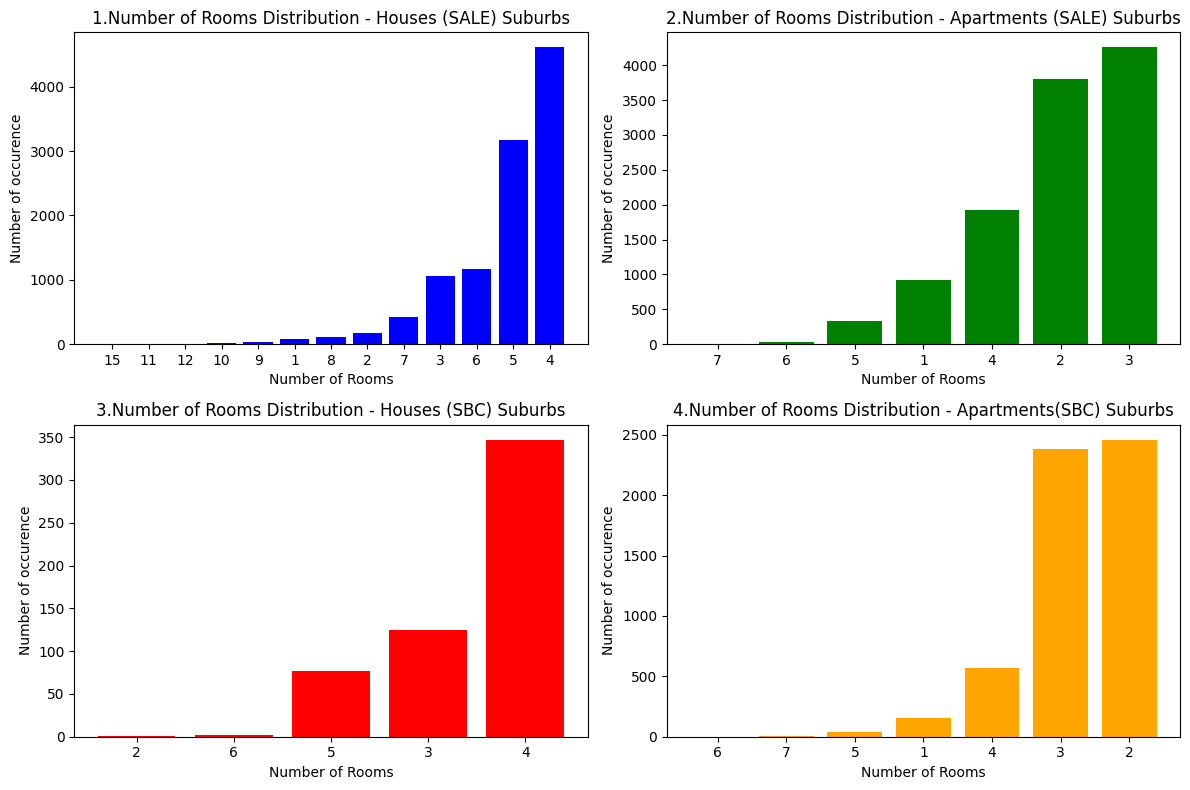

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrames to Pandas DataFrames for plotting
houses_sale_count_pd_suburbs = houses_sale_count_by_rooms_suburbs.toPandas()
apartments_sale_count_pd_suburbs = apartments_sale_count_by_rooms_suburbs.toPandas()
houses_before_completion_count_pd_suburbs = houses_before_completion_count_by_rooms_suburbs.toPandas()
apartments_before_completion_count_pd_suburbs = apartments_before_completion_count_by_rooms_suburbs.toPandas()

# Plotting
plt.figure(figsize=(12, 8))

# Plot for 'SALE' houses in suburbs
plt.subplot(2, 2, 1)
plt.bar(houses_sale_count_pd_suburbs['NbRooms'], houses_sale_count_pd_suburbs['count'], color='blue')
plt.title('1.Number of Rooms Distribution - Houses (SALE) Suburbs')
plt.xlabel('Number of Rooms')
plt.ylabel('Number of occurence')

# Plot for 'SALE' apartments in suburbs
plt.subplot(2, 2, 2)
plt.bar(apartments_sale_count_pd_suburbs['NbRooms'], apartments_sale_count_pd_suburbs['count'], color='green')
plt.title('2.Number of Rooms Distribution - Apartments (SALE) Suburbs')
plt.xlabel('Number of Rooms')
plt.ylabel('Number of occurence')

# Plot for 'SALE BEFORE COMPLETION' houses in suburbs
plt.subplot(2, 2, 3)
plt.bar(houses_before_completion_count_pd_suburbs['NbRooms'], houses_before_completion_count_pd_suburbs['count'], color='red')
plt.title('3.Number of Rooms Distribution - Houses (SBC) Suburbs')
plt.xlabel('Number of Rooms')
plt.ylabel('Number of occurence')

# Plot for 'SALE BEFORE COMPLETION' apartments in suburbs
plt.subplot(2, 2, 4)
plt.bar(apartments_before_completion_count_pd_suburbs['NbRooms'], apartments_before_completion_count_pd_suburbs['count'], color='orange')
plt.title('4.Number of Rooms Distribution - Apartments(SBC) Suburbs')
plt.xlabel('Number of Rooms')
plt.ylabel('Number of occurence')

plt.tight_layout()
plt.show()

1. 4-room houses are the most common in sales, followed by 5 room and 3 room houses.
2. 3 room apartments have the highest occurrence in sales,followed by 2 rooms.
3. 4 room houses are the most common in the SBC category.
4. There is a strong preference for 2 room apartments ,closely followed by 3 rooms.


#6. Calculating the Unused Area


For Houses and apartments

In [ ]:
from pyspark.sql.functions import col

# Calculating unused_area for houses
houses_area1 = houses_df.withColumn("unused_area", col("LandArea") - col("LivingArea"))

# Calculate unused_area for apartments
apartments_area1 = apartments_df.withColumn("unused_area", col("LandArea") - col("LivingArea"))

# Unused_area is greater than 0 for houses
count_unused_area_gt_0_houses = houses_area1.filter(col("unused_area") > 0).count()

# not equal to 0 for apartments
count_unused_area_gt_0_apartments = apartments_area1.filter(col("unused_area") != 0).count()

# Return the results
print(f" houses_df: {count_unused_area_gt_0_houses}")
print(f" apartments_df: {count_unused_area_gt_0_apartments}")


Count of rows with unused_area > 0 in houses_df: 14765
Count of rows with unused_area > 0 in apartments_df: 62483


The number of houses with more land area than living area is 14,765. The number of apartments with land area not equal to the living area is
62,483. Its important to note that almost 99% of the apartments sold do not have a seperate land area unlike houses.

#Conclusion

After running the analysis above the followed insights are highlighted:

1. Average Price Trends:
   The analysis reveals that the average price per square meter in Toulouse is approximately 11838.16 euros. Notably, there is a considerable variation in prices for smaller apartments, indicating a diverse real estate market.

2. Regional Price Dynamics:
   Postcode 31000 emerges as a standout area with the highest average price per square meter, while prices generally decrease from postcode 31400 onwards. This suggests distinct regional pricing dynamics within the city.

3. Property Size Preferences:
   4-room houses dominate the real estate landscape, constituting 81% of total house sales. On the other hand, customer preferences lean towards smaller apartments, with 1, 2, and 3-room units contributing to 82% of apartment sales.

4. Yearly Price Variability:
   The analysis uncovers substantial year-over-year variability in house prices, marked by a notable drop in 2017 and a significant rise in 2019. Apartments exhibit a similar trend, with fluctuations in 2016, 2017, and 2018.

5. Correlation Insights:
   The data suggests a weak positive correlation between the number of houses sold and the average price per square meter. In contrast, there is a moderately positive correlation between the number of apartments sold and their average price per square meter. These insights provide valuable information for understanding market trends and informing real estate decisions in Toulouse.
   
These insights provide a comprehensive understanding of the real estate market trends, regional variations, and customer preferences in Toulouse. The analysis indicates the importance of factors such as living area, number of rooms, and geographical location in influencing property prices and sales patterns.